In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv("datasets/target_molecules_clean.csv")
df.head()

,pIC50,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_2038,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047
0,-0.301030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.301030,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.301030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.531653,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.337242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
threshold = 5.0
df['activity_class'] = (df['pIC50'] >= threshold).astype(int)

# Check the class distribution
class_distribution = df['activity_class'].value_counts(normalize=True) * 100

class_distribution

activity_class
0    71.318822
1    28.681178
Name: proportion, dtype: float64

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Binning pIC50 values into active (1) and inactive (0) classes
threshold = 5.0
df['activity_class'] = (df['pIC50'] >= threshold).astype(int)

# Data Splitting Strategy
train_data, temp_data = train_test_split(df, test_size=0.3, stratify=df['activity_class'], random_state=42)
valid_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['activity_class'], random_state=42)

X_train_class = train_data.iloc[:, 1:-2]  # Exclude the pIC50 and activity_class columns
y_train_class = train_data['activity_class']

X_valid_class = valid_data.iloc[:, 1:-2]
y_valid_class = valid_data['activity_class']

df.head()



,pIC50,ECFP4_0,ECFP4_1,ECFP4_2,ECFP4_3,ECFP4_4,ECFP4_5,ECFP4_6,ECFP4_7,ECFP4_8,...,ECFP4_2039,ECFP4_2040,ECFP4_2041,ECFP4_2042,ECFP4_2043,ECFP4_2044,ECFP4_2045,ECFP4_2046,ECFP4_2047,activity_class
0,-0.301030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,-0.301030,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,-0.301030,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3.531653,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.337242,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# Compute class weights to handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
import xgboost as xgb
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train_class)
weights = {0: class_weights[0], 1: class_weights[1]}

# Initialize the XGBoost classifier with class weights
xgb_classifier_weighted = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=weights[1])

# Train the classifier
xgb_classifier_weighted.fit(X_train_class, y_train_class)

# Predict on the validation set
y_pred_class_xgb_weighted = xgb_classifier_weighted.predict(X_valid_class)

# Calculate performance metrics
accuracy_xgb_weighted = accuracy_score(y_valid_class, y_pred_class_xgb_weighted)
classification_rep_xgb_weighted = classification_report(y_valid_class, y_pred_class_xgb_weighted)

# Convert the classification report to a dictionary
report_dict_xgb_weighted = classification_report(y_valid_class, y_pred_class_xgb_weighted, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df_xgb_weighted = pd.DataFrame(report_dict_xgb_weighted).transpose()

accuracy_xgb_weighted, report_df_xgb_weighted


c:\Users\m1000\anaconda3\envs\my-rdkit-env\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


(0.8290598290598291,
               precision    recall  f1-score    support
 0              0.850829  0.922156  0.885057  167.00000
 1              0.754717  0.597015  0.666667   67.00000
 accuracy       0.829060  0.829060  0.829060    0.82906
 macro avg      0.802773  0.759585  0.775862  234.00000
 weighted avg   0.823310  0.829060  0.822527  234.00000)

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

grid_search = GridSearchCV(estimator=xgb_classifier_weighted, param_grid=param_grid, 
                           scoring='precision', cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train_class, y_train_class)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_parameters)
print("Best Score:", best_score)



c:\Users\m1000\anaconda3\envs\my-rdkit-env\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\m1000\anaconda3\envs\my-rdkit-env\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best Score: 0.7928122619954303


In [12]:
from sklearn.metrics import classification_report, confusion_matrix

# 1. Get the best estimator
best_model = grid_search.best_estimator_

# 2. Predict on the validation set using the best model
y_pred_best = best_model.predict(X_valid_class)

# 3. Compute the classification report
classification_rep_best = classification_report(y_valid_class, y_pred_best)

# Convert the classification report to a dictionary
report_dict_best = classification_report(y_valid_class, y_pred_best, output_dict=True)

# Convert the dictionary to a pandas DataFrame
report_df_best = pd.DataFrame(report_dict_best).transpose()
report_df_xgb_weighted_best = pd.DataFrame(report_df_best).transpose()
# 4. Compute the confusion matrix
conf_matrix = confusion_matrix(y_valid_class, y_pred_best)

report_df_xgb_weighted_best, conf_matrix


(                    0          1  accuracy   macro avg  weighted avg
 precision    0.853933   0.732143  0.824786    0.793038      0.819061
 recall       0.910180   0.611940  0.824786    0.761060      0.824786
 f1-score     0.881159   0.666667  0.824786    0.773913      0.819745
 support    167.000000  67.000000  0.824786  234.000000    234.000000,
 array([[152,  15],
        [ 26,  41]], dtype=int64))

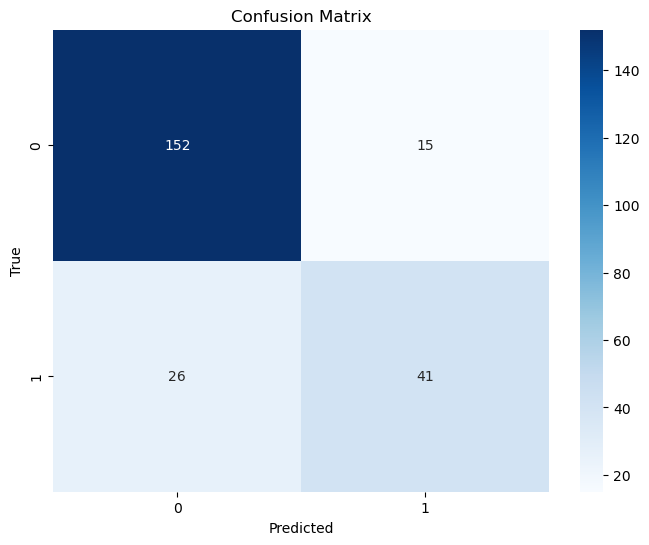

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for the classes
labels = [0, 1]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
